## Linear regression on the Boston House Prices dataset

In this exercise, you will perform linear regression on the Boston House Prices dataset.

This dataset contains median house prices in different areas around Boston. For each area, we have some information about it, that we will use as our features. We want to train a linear regression model that predicts the price of a house given the input features.

We don't have direct access to the dataset from PyTorch, but the `scikit` library provides a version of it.

An important part of the exercise will be to get used to process input dataset and translate it into a suitable format for your analysis.

In [1]:
# Import dataset
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

dataset = load_boston()

C:\Users\utente\miniconda3\envs\homework1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

In [2]:
print(dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Play around with the `dataset` variable to see what it contains. It is a *dictionary*, i.e. a Python structure with key-value pairs, where the keys can be arbitrary objects --- usually strings. 

To access the item with key `key` from a dictionary `dictionary`, use the syntax `dictionary[key]`.

The `keys()` method of a dictionary returns the set of keys. To start, try `print()`ing the contents of the the `DESCR` key.

The data in the dataset are Numpy arrays. To convert them to PyTorch tensors, just pass the array as the single argument of the `torch.tensor()` function.

From this point, prepare the data to process it as done in the previous exercise.

## Tensor loading

In [3]:
tensor_data = torch.from_numpy(dataset['data'])
tensor_target = torch.from_numpy(dataset['target'])
if torch.cuda.is_available():
    tensor_data = tensor_data.to('cuda')
    tensor_target = tensor_target.to('cuda')


In [4]:
print(f'Data tensor size: {tensor_data.size()}\nTarget tensor size: {tensor_target.size()}')

Data tensor size: torch.Size([506, 13])
Target tensor size: torch.Size([506])


### Correlations

One of the things you may want to do is remove unnecessary features. For example, if you have two highly-correlated features, you could use only one of them.

Feature correlation can be estimated using the Pearson correlation coefficient:

$$\text{corr}_{X_1,X_2} = \frac{\text{cov}(X_1,X_2)}{\sigma_{X_1} \sigma_{X_2}}$$

where $\text{cov}(X_1,X_2)$ is the covariance between features $X_1$ and $X_2$ (i.e., all values for that feature, from all observations), and $\sigma_X$ is the standard deviation of feature $X$.

All values $X_i$ are basically the columns of our data matrix. Given the vector `X_i` that contains all values for a feature, you can use the `X_i.std()` function to get the standard deviation of that vector.

You can also use the variant of `std()` that takes an input `dim` argument to compute *all* standard deviations for each column in the full data matrix.

To compute the covariance matrix, you are going to need to perform some computations. This is a good training exercise to learn how to manipulate tensors, while will be very useful later.

Let's suppose your data matrix is `X`, where each row is an observation and each column is a feature.

First of all, you will need to compute a vector `X_mean`, where each element is the mean value for each feature. To do this, you will need to use the `torch.mean()` or the `Tensor.mean()` function.

From there, you have to subtract the mean vector to each observation in the data matrix. Note that PyTorch supports an operation called *broadcasting*. In practice, if `X` has size $n \times d$, and if `X_mean` has size $d$ or $1 \times d$, then `X - X_mean` will automatically subtract `X_mean` from each row in `X`.

Finally, if $N$ is the number of observation and `X_cent` is the data matrix where the mean vector has been subtracted, you can compute the covariance matrix $\Sigma$ as:

$$\Sigma = \frac{X_{\text{cent}}^T X_{\text{cent}}}{N-1}$$

Each element $\Sigma_{ij}$ is going to be equal to $\text{cov}(X_i,X_j)$. From those values and from the $\sigma_i$ values, you can compute the correlation matrix.

In [5]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, double_sided_threshold=False, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    double_sided_threshold
        Toggle double-sided threshold.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None and not double_sided_threshold:
        threshold1 = im.norm(threshold)
    elif threshold is None:
        threshold1 = im.norm(data.max()) / 2.
    else:
        threshold1 = im.norm(threshold)
        threshold2 = im.norm(-threshold)

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[
                int(im.norm(data[i, j]) > threshold1 or (double_sided_threshold and im.norm(data[i, j]) < threshold2))])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def format_func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

In [6]:
# Perform covariance matrix calculation
data_mean = tensor_data.mean(0)
cov_mat_ij = ((tensor_data - data_mean).T @ (tensor_data - data_mean)) / (tensor_data.size(0))
diagonal = cov_mat_ij.diag()
stddev = diagonal.sqrt()

Real correlation coefficient matrix:
tensor([[ 1.0000, -0.2005,  0.4066, -0.0559,  0.4210, -0.2192,  0.3527, -0.3797,
          0.6255,  0.5828,  0.2899, -0.3851,  0.4556],
        [-0.2005,  1.0000, -0.5338, -0.0427, -0.5166,  0.3120, -0.5695,  0.6644,
         -0.3119, -0.3146, -0.3917,  0.1755, -0.4130],
        [ 0.4066, -0.5338,  1.0000,  0.0629,  0.7637, -0.3917,  0.6448, -0.7080,
          0.5951,  0.7208,  0.3832, -0.3570,  0.6038],
        [-0.0559, -0.0427,  0.0629,  1.0000,  0.0912,  0.0913,  0.0865, -0.0992,
         -0.0074, -0.0356, -0.1215,  0.0488, -0.0539],
        [ 0.4210, -0.5166,  0.7637,  0.0912,  1.0000, -0.3022,  0.7315, -0.7692,
          0.6114,  0.6680,  0.1889, -0.3801,  0.5909],
        [-0.2192,  0.3120, -0.3917,  0.0913, -0.3022,  1.0000, -0.2403,  0.2052,
         -0.2098, -0.2920, -0.3555,  0.1281, -0.6138],
        [ 0.3527, -0.5695,  0.6448,  0.0865,  0.7315, -0.2403,  1.0000, -0.7479,
          0.4560,  0.5065,  0.2615, -0.2735,  0.6023],
        [-0

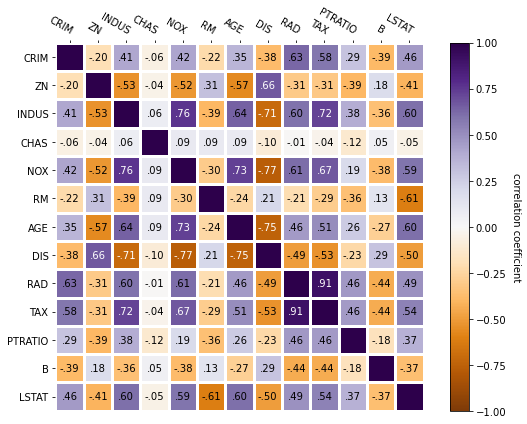

In [7]:
# Real correlation matrix
corr_coeff = cov_mat_ij / stddev.view(-1, 1) / stddev.view(1, -1)
print('Real correlation coefficient matrix:\n' + str(corr_coeff))
_, ax = plt.subplots(figsize=(8, 6))
im, _ = heatmap(corr_coeff.to('cpu'), dataset['feature_names'], dataset['feature_names'], ax=ax, cmap='PuOr',
                cbarlabel='correlation coefficient', vmin=-1, vmax=1)
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(format_func), textcolors=('black', 'white'), threshold=0.65,
                 double_sided_threshold=True)
plt.tight_layout()

## Correlation matrix interpretation
In the correlation matrix, all the values above 0.65 and below -0.65 are in *white* color so that we can distinguish them easily.

Because of strong correlations with other features, in this case we can remove the following features:
- NOX
- TAX
- DIS

In [8]:
def calculate_mse(input_tensor, test_size_percentage=0.30):
    """
    Split dataset, apply Least Squares method and return train and test MSE

    :param input_tensor: tensor containing the input data
    :param test_size_percentage: percentage (from 0 to 1) of the test dataset
    :return: train MSE and test MSE
    """
    # Perform random dataset splitting (by default, 30% will be the test dataset)
    split_train_data, split_test_data, split_train_target, split_test_target = train_test_split(input_tensor,
                                                                                                dataset['target'],
                                                                                                test_size=test_size_percentage,
                                                                                                random_state=42)
    split_train_target = torch.from_numpy(split_train_target)
    split_test_target = torch.from_numpy(split_test_target)
    if torch.cuda.is_available():
        split_train_target = split_train_target.to('cuda')
        split_test_target = split_test_target.to('cuda')

    # Perform least-squares method
    beta = (split_train_data.T @ split_train_data).inverse() @ split_train_data.T @ split_train_target

    # Calculating the MSE from training data and testing data
    train_mse = (((split_train_target - split_train_data @ beta) ** 2).sum() / split_train_target.size(0)).item()
    test_mse = (((split_test_target - split_test_data @ beta) ** 2).sum() / split_test_target.size(0)).item()
    return train_mse, test_mse

In [9]:
# Here we filter the original tensor by excluding the indices corresponding to the features NOX, TAX and DIS from the second dimension
tensor_filter = [i for i, item in enumerate(dataset['feature_names']) if
                 item != 'NOX' and item != 'TAX' and item != 'DIS']
filtered_tensor = tensor_data[:, tensor_filter]

In [34]:
# Calculating the MSE from training data and testing data
train_mse, test_mse = calculate_mse(filtered_tensor, 0.30)
print('*\tMSE metrics after removing features: NOX, TAX and DIS\t*\n'
      '*\t*****\t*****\t*****\t*****\t*****\t*****\t*****\t*')
print(f'*\t\tTrain MSE:\t{train_mse}\t\t*\n*\t\tTest MSE:\t{test_mse}\t\t*\n'
      f'*\t******\t******\t******\t******\t******\t******\t******\t*')

*	MSE metrics after removing features: NOX, TAX and DIS	*
*	*****	*****	*****	*****	*****	*****	*****	*
*		Train MSE:	25.5833850663775		*
*		Test MSE:	27.031279643029034		*
*	******	******	******	******	******	******	******	*


An additional test you can carry out is to see which feature mostly correlate *with the targets*, to see which features are most important for regression.

**Note that you should do this on the training set only. You can't look at the test set during training.**

To do so, you can create an "extended" data matrix `data_ext` where the targets have been added as a new feature column. Then you can run the correlation analysis to see which features are mostly related.

Finally, run some tests by:

- Computing the accuracy of your model when you remove/keep features that correlate with each other.
- Computing the accuracy of your model when you remove/keep features that correlate with the targets.